# Introduction

The medication status of PD patient is important as medication importantly affects behavioral measures such as the Hoehn & Yahr score used in many studies. In PPMI, medication is available through the following main variables:
* PDSTATE (ON/OFF): the current functional state of the patient
* PDTRTMNT (0/1): 1 if the participant is on PD medication or receives deep brain stimulation, 0 otherwise
* PDMEDTM: time of most recent PD medication dose
* PDMEDDT: date of most recent PD medication dose


The goal of this notebook is (1) to identify and correct inconsistencies among these variables, (2) to impute missing data for PDSTATE and PDTRTMNT, and (3) to check the sanity of the corrected dataset.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')


# Data download

The above-mentioned variables are available in PPMI file 'MDS_UPDRS_Part_III.csv'. Let's download this file:

In [2]:
import os
import os.path as op
import pandas as pd
import ppmi_downloader

data_dir = 'data'

if not op.exists(data_dir):
    os.makedirs(data_dir)
required_files = ['MDS_UPDRS_Part_III.csv']
missing_files = [x for x in required_files if not op.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader('ADD YOUR PPMI LOGIN HERE', 'ADD YOUR PPMI PASSWORD HERE')
    ppmi.download_metadata(missing_files, destination_dir=data_dir, headless=False, timeout=600)

df = pd.read_csv(op.join(data_dir, 'MDS_UPDRS_Part_III.csv'))

print('File downloaded')

File downloaded


/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (10,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Inconsistencies

## PDTRTMNT=0 and PDSTATE=ON

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem:</b> a few (10) records have PDSTATE=ON and PDTRTMNT=0, which is inconsistent:
</div>

In [3]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0           18     18        18        18      18        4        4   
        1.0         3072   3072      3072      3072    3072     3025     3022   
        NaN            6      6         6         6       6        0        0   
ON      0.0           10     10        10        10      10       10       10   
        1.0         5175   5175      5175      5175    5175     5106     5104   
        NaN            1      1         1         1       1        0        0   
NaN     0.0         7421   7421      7421      7421    7421      472      470   
        1.0          163    163       163       163     163      134      134   
        NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0           18           0       18  ...        18         2    18   
        1.0         3033          91     3072  ...      3072       640  3070   
        NaN            6           0        6  ...         6         0     6   
ON      0.0           10           0       10  ...        10         2    10   
        1.0         5140         152     5175  ...      5172      1623  5172   
        NaN            1           0        1  ...         1         0     1   
NaN     0.0         5806           0     7421  ...      7417      1661  7418   
        1.0          134           0      135  ...       135        18   135   
        NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0          18   
        1.0            13        51       2992        51        0        3072   
        NaN             0         0          0         0        0           6   
ON      0.0             0         0          3         0        0          10   
        1.0           106        13       5081         0      106        5175   
        NaN             0         0          0         0        0           1   
NaN     0.0             0         0          0         0        0        7421   
        1.0             0         0          0         0        0         163   
        NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0                18  
        1.0              3072  
        NaN                 6  
ON      0.0                10  
        1.0              5175  
        NaN                 1  
NaN     0.0              7421  
        1.0               163  
        NaN              2418  

[9 rows x 53 columns]

The lines below show the difference between EXAMTM and PDMEDTM. All the records have a PDMEDTM that is earlier or equal to EXAMTM.

In [4]:
errors = df[(df['PDSTATE']=='ON') & (df['PDTRTMNT']==0)]
# print the time difference between EXAMTM and PDMEDTM
(pd.to_datetime(errors['EXAMTM'])-pd.to_datetime(errors['PDMEDTM']))

6534    0 days 01:00:00
7368    0 days 01:00:00
8040    0 days 01:25:00
10463   0 days 04:30:00
11475   0 days 00:40:00
11504   0 days 00:00:00
11505   0 days 01:54:00
15632   0 days 03:50:00
17176   0 days 00:15:00
17644   0 days 05:00:00
dtype: timedelta64[ns]

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction</b>: set PDTRTMNT to 1 for these records. It doesn't seem realistic that a plausible PDMEDTM and PDSTATE=ON have been entered by mistake while the patient was not under medication.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [5]:
df.loc[df['PDSTATE']=='ON', 'PDTRTMNT'] = 1 

Let's verify that the inconsistency is now resolved:

In [6]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0           18     18        18        18      18        4        4   
        1.0         3072   3072      3072      3072    3072     3025     3022   
        NaN            6      6         6         6       6        0        0   
ON      1.0         5186   5186      5186      5186    5186     5116     5114   
NaN     0.0         7421   7421      7421      7421    7421      472      470   
        1.0          163    163       163       163     163      134      134   
        NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0           18           0       18  ...        18         2    18   
        1.0         3033          91     3072  ...      3072       640  3070   
        NaN            6           0        6  ...         6         0     6   
ON      1.0         5151         152     5186  ...      5183      1625  5183   
NaN     0.0         5806           0     7421  ...      7417      1661  7418   
        1.0          134           0      135  ...       135        18   135   
        NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0          18   
        1.0            13        51       2992        51        0        3072   
        NaN             0         0          0         0        0           6   
ON      1.0           106        13       5084         0      106        5186   
NaN     0.0             0         0          0         0        0        7421   
        1.0             0         0          0         0        0         163   
        NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0                18  
        1.0              3072  
        NaN                 6  
ON      1.0              5186  
NaN     0.0              7421  
        1.0               163  
        NaN              2418  

[7 rows x 53 columns]

## PDTRTMNT=0 and PDMEDTM not empty

<div class="alert alert-block alert-danger">
 	&#10060; <b>Problem:</b> some records have a non-empty PDMEDTIME while PDTRTMNT=0, which is inconsistent.
    </div>

Number of records with a non-empty PDMEDTIME and PDTRTMNT=0:

In [7]:
errors = df[(df['PDMEDTM'].notnull()) & (df['PDTRTMNT']==0)]
len(errors)

474

Most of these records do not have a PDSTATE:

In [8]:
errors.groupby('PDSTATE',dropna=False).count()

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDMEDDT,PDMEDTM,EXAMTM,DBS_STATUS,NP3SPCH,...,DYSKIRAT,NHY,PDTRTMNT,DBSONTM,DBSOFFTM,HRPOSTMED,HRDBSOFF,HRDBSON,ORIG_ENTRY,LAST_UPDATE
PDSTATE,,,,,,,,,,,,,,,,,,,,,
OFF,4,4,4,4,4,4,4,4,0,4,...,2,4,4,0,0,0,0,0,4,4
NaN,470,470,470,470,470,470,470,470,0,470,...,4,470,470,0,0,0,0,0,470,470


<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction:</b> discard the records. There is no obvious reason to trust variable PDTRTMNT more than PDMEDTM.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [9]:
before = len(df)
df = df[(df['PDMEDTM'].isnull()) | (df['PDTRTMNT']!=0)]
print(f'Number of records removed:\t{before - len(df)}')
print(f"Remaining inconsistencies:\t" +
      f"{len(df[(df['PDMEDTM'].notnull()) & (df['PDTRTMNT']==0)])}")

Number of records removed:	474
Remaining inconsistencies:	0


## EVENT_ID = BL and PDTRTMNT = 1

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem</b>: Some patients were on medication at baseline while PPMI patients were supposed to be unmedicated at baseline.
    </div>

Number of patients on medication at baseline:

In [10]:
len(df[(df['EVENT_ID']=='BL') & (df['PDTRTMNT']==1)])

416

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction:</b> talk to Madeleine.
</div>

## Visits with 3 exams

<div class="alert alert-block alert-danger">
    	&#10060; <b>Problem</b>: some visits have 3 exams:
</div>

In [11]:
pb = df.groupby(['PATNO', 'EVENT_ID']).filter(lambda x: len(x)==3).drop([x for x in df.columns 
                                                                    if x not in ['EVENT_ID', 'EXAMTM', 'PDSTATE']],
                                                                  axis=1)
from IPython.display import HTML
HTML(pb[:10].to_html(index=False))

EVENT_ID,PDSTATE,EXAMTM
V16,NaN,NaN
V16,NaN,NaN
V16,ON,10:30:00
V16,NaN,NaN
V16,OFF,08:00:00
V16,ON,08:50:00
V17,ON,12:09:00
V17,NaN,NaN
V17,OFF,09:30:00
V17,NaN,NaN


<div class="alert alert-block alert-success">
  	&#10003;   <b>Proposed correction:</b> talk to Madeleine.
</div>

# Missing PDSTATE and PDTRTMNT data imputation

<div class="alert alert-block alert-danger">
    	&#10060; <b>Problem:</b> variables PDSTATE and PDTRTMNT have missing data, which makes it difficult to identify when/if a patient was under medication.
</div>

In [12]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0           14     14        14        14      14        0        0   
        1.0         3072   3072      3072      3072    3072     3025     3022   
        NaN            6      6         6         6       6        0        0   
ON      1.0         5186   5186      5186      5186    5186     5116     5114   
NaN     0.0         6951   6951      6951      6951    6951        2        0   
        1.0          163    163       163       163     163      134      134   
        NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0           14           0       14  ...        14         0    14   
        1.0         3033          91     3072  ...      3072       640  3070   
        NaN            6           0        6  ...         6         0     6   
ON      1.0         5151         152     5186  ...      5183      1625  5183   
NaN     0.0         5336           0     6951  ...      6947      1657  6948   
        1.0          134           0      135  ...       135        18   135   
        NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0          14   
        1.0            13        51       2992        51        0        3072   
        NaN             0         0          0         0        0           6   
ON      1.0           106        13       5084         0      106        5186   
NaN     0.0             0         0          0         0        0        6951   
        1.0             0         0          0         0        0         163   
        NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0                14  
        1.0              3072  
        NaN                 6  
ON      1.0              5186  
NaN     0.0              6951  
        1.0               163  
        NaN              2418  

[7 rows x 53 columns]

The following cases occur and will be treated separately in the following sections:

|               |PDSTATE | PDTRTMNT | Number of records |
|---------------|--------|----------|-------------------|
| **Case (i)**  | OFF    | NaN      | 6                 |
| **Case (ii)** | NaN    | 0        | 7,421             |
| **Case (iii)**|  NaN   | 1        | 163               |
| **Case (iv)** | NaN    | NaN      | 2,418             |
| **Case (v)**  | ON     | NaN      | 1                 |

## Case (i): PDSTATE=OFF and PDTRTMNT=NaN

No record in case (i) has a medication date (PDMEDDT), a medication time (PDMEDTM), or
a DBS status (DBS_STATUS):

In [13]:
case_i = df[(df['PDSTATE']=='OFF') & (df['PDTRTMNT'].isnull())]
case_i.groupby(['PDMEDDT', 'PDMEDTM', 'DBS_STATUS', 'HRPOSTMED', 'DBSONTM',
                'DBSOFFTM', 'HRDBSOFF', 'HRDBSON'], dropna=False).count()

,,,,,,,,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDSTATE,EXAMTM,NP3SPCH,NP3FACXP,NP3RIGN,...,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,DYSKIRAT,NHY,PDTRTMNT,ORIG_ENTRY,LAST_UPDATE
PDMEDDT,PDMEDTM,DBS_STATUS,HRPOSTMED,DBSONTM,DBSOFFTM,HRDBSOFF,HRDBSON,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,0,6,0,6,6


<div class="alert alert-block alert-success">
 	&#10003;    <b>Proposed correction</b>: set PDTRTMNT=0. It is unlikely that these records correspond to medicated patients when none of the variables related to medication have a value.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [14]:
df.loc[(df['PDSTATE']=='OFF') & (df['PDTRTMNT'].isnull()), 'PDTRTMNT'] = 0

Let's verify that case (i) is now resolved:

In [15]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0           20     20        20        20      20        0        0   
        1.0         3072   3072      3072      3072    3072     3025     3022   
ON      1.0         5186   5186      5186      5186    5186     5116     5114   
NaN     0.0         6951   6951      6951      6951    6951        2        0   
        1.0          163    163       163       163     163      134      134   
        NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0           20           0       20  ...        20         0    20   
        1.0         3033          91     3072  ...      3072       640  3070   
ON      1.0         5151         152     5186  ...      5183      1625  5183   
NaN     0.0         5336           0     6951  ...      6947      1657  6948   
        1.0          134           0      135  ...       135        18   135   
        NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0          20   
        1.0            13        51       2992        51        0        3072   
ON      1.0           106        13       5084         0      106        5186   
NaN     0.0             0         0          0         0        0        6951   
        1.0             0         0          0         0        0         163   
        NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0                20  
        1.0              3072  
ON      1.0              5186  
NaN     0.0              6951  
        1.0               163  
        NaN              2418  

[6 rows x 53 columns]

## Case (ii): PDSTATE=NaN and PDTRTMNT=0

<div class="alert alert-block alert-success">
   	&#10003;   <b>Proposed correction</b>: set PDSTATE=OFF. The patient is not medicated.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [16]:
df.loc[(df['PDSTATE'].isnull()) & (df['PDTRTMNT']==0), 'PDSTATE'] = 'OFF'

Let's verify that case (ii) is now resolved:

In [17]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0         6971   6971      6971      6971    6971        2        0   
        1.0         3072   3072      3072      3072    3072     3025     3022   
ON      1.0         5186   5186      5186      5186    5186     5116     5114   
NaN     1.0          163    163       163       163     163      134      134   
        NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0         5356           0     6971  ...      6967      1657  6968   
        1.0         3033          91     3072  ...      3072       640  3070   
ON      1.0         5151         152     5186  ...      5183      1625  5183   
NaN     1.0          134           0      135  ...       135        18   135   
        NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0        6971   
        1.0            13        51       2992        51        0        3072   
ON      1.0           106        13       5084         0      106        5186   
NaN     1.0             0         0          0         0        0         163   
        NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0              6971  
        1.0              3072  
ON      1.0              5186  
NaN     1.0               163  
        NaN              2418  

[5 rows x 53 columns]

## Case (iii): PDSTATE=NaN and PDTRTMNT=1

<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction</b>: determine PDSTATE as a function of PDMEDTM and EXAMTM:
    <ul>
        <li> (iii.a) If PDMEDTM is earlier than EXAMTM on the day of the exam, then PDSTATE=ON</li>
        <li> (iii.b) If PDMEDTM is later than EXAMTM on the day of the exam, then PDSTATE=OFF</li>
        <li>(iii.c) If PDMEDTM is on the day before the exam, then PDSTATE=OFF</li>
        <li>(iii.d) If PDMEDTM or EXAMTM are missing: discard record.</li>
    </ul>
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>


Implementing this correction isn't straightforward because dates only contain a month and a year but no day. For instance, the following record shows a visit where medication was taken at 22:30:00 and exam time was 10:00:00. It is very likely that medication was taken on the day before the exam, although this information is not available in the data.

In [18]:
case_iii = df[(df['PDSTATE'].isnull()) & (df['PDTRTMNT']==1)]
case_iii.drop([x for x in case_iii.columns if x not in ['INFODT', 'PDMEDDT', 'PDMEDTM', 'EXAMTM']],
              axis=1).iloc[7]

INFODT      12/2018
PDMEDDT     12/2018
PDMEDTM    22:30:00
EXAMTM     10:00:00
Name: 1788, dtype: object

**Note:** PPMI document "Methods for Defining PD Med Use" mentions that "an algorithm is used to calculate the time between doses and assessments for all subjects who are taking LEV/DA Or are taking a combination of LEV/DA and another PD drug". It would have been very useful to have access to this algorithm.

To address this issue, we note that exam times are all before 15:00 (3pm), while PDMEDTM also occur after 15:00:

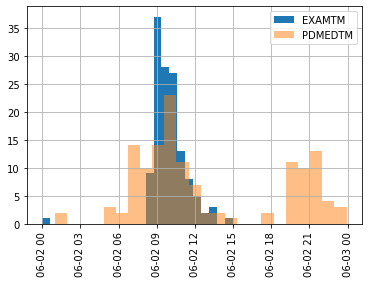

In [19]:
from matplotlib import pyplot as plt
pd.to_datetime(case_iii['EXAMTM']).hist(bins=24, xrot=90, legend=True)
pd.to_datetime(case_iii['PDMEDTM']).hist(bins=24, xrot=90, legend=True, alpha=0.5)
plt.show()

The latest value for EXAMTM is indeed exactly 15:00:00:

In [20]:
pd.to_datetime(case_iii['EXAMTM']).max()

Timestamp('2022-06-02 15:00:00')

Therefore, we consider that if PDMEDTM is after 15:00 then it is on the day before the exam (case iii.c). Using this threshold leads to the following:

In [21]:
def guess_pd_state(record):
    '''
    Guess the PDSTATE value of record
    '''
    # extract pdmed and exam times
    pdmedtm = record['PDMEDTM']
    examtm = record['EXAMTM']
    
    # convert strings to dates
    pdmedtm = pd.to_datetime(pdmedtm)
    examtm = pd.to_datetime(examtm)

    # case iii.c
    if pdmedtm.hour >= 15:
        return 'OFF'
        
    # case iii.b
    if pdmedtm > examtm:
        return 'OFF'
    
    # case iii.a
    if pdmedtm <= examtm:
        return 'ON'
    
    raise(Exception(f'This should never occur! {record}'))

# case iii.d
# remove records for which PDSTATE=NaN and PDTRTMNT=1 and (EXAMTM=NaN or PDMEDTME=NaN)
# i.e., keep records for which PDSTATE!=NaN or PDTRTMNT!=1 or (EXAMTM!=NaN and PDMEDTM!=NaN)
before = len(df)
df = df[(df['PDSTATE'].notnull()) | (df['PDTRTMNT']!=1) | ((df['EXAMTM'].notnull()) & df['PDMEDTM'].notnull())]
print(f'Removed {before-len(df)} records with EXAMTM=NaN or PDMEDTM=NaN')

# cases iii.a,b,c: apply guess_pd_state
df.loc[(df['PDSTATE'].isnull()) & (df['PDTRTMNT']==1), 'PDSTATE'] = \
                df.loc[(df['PDSTATE'].isnull()) & (df['PDTRTMNT']==1)].apply(guess_pd_state, axis=1)

Removed 29 records with EXAMTM=NaN or PDMEDTM=NaN


Let's verify that case (iii) is now resolved:

In [22]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0         6971   6971      6971      6971    6971        2        0   
        1.0         3166   3166      3166      3166    3166     3119     3116   
ON      1.0         5226   5226      5226      5226    5226     5156     5154   
NaN     NaN         2418   2418      2418      2418    2418        0        0   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0         5356           0     6971  ...      6967      1657  6968   
        1.0         3127          91     3166  ...      3166       655  3164   
ON      1.0         5191         152     5226  ...      5223      1628  5223   
NaN     NaN         1135           0     2322  ...      2320        40  2320   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0        6971   
        1.0            13        51       2992        51        0        3166   
ON      1.0           106        13       5084         0      106        5226   
NaN     NaN             0         0          0         0        0        2418   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0              6971  
        1.0              3166  
ON      1.0              5226  
NaN     NaN              2418  

[4 rows x 53 columns]

## Case (iv): PDSTATE=NaN and PDTRTMNT=NaN

Similar to case (i), no record in case (iv) has a medication date (PDMEDDT), a medication time (PDMEDTM), or
a DBS status (DBS_STATUS):

In [23]:
case_iv = df[(df['PDSTATE'].isnull()) & (df['PDTRTMNT'].isnull())]
case_iv.groupby(['PDMEDDT', 'PDMEDTM', 'DBS_STATUS', 'HRPOSTMED', 'DBSONTM',
                'DBSOFFTM', 'HRDBSOFF', 'HRDBSON'], dropna=False).count()

,,,,,,,,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDSTATE,EXAMTM,NP3SPCH,NP3FACXP,NP3RIGN,...,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,DYSKIRAT,NHY,PDTRTMNT,ORIG_ENTRY,LAST_UPDATE
PDMEDDT,PDMEDTM,DBS_STATUS,HRPOSTMED,DBSONTM,DBSOFFTM,HRDBSOFF,HRDBSON,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2418,2418,2418,2418,2418,0,1135,2322,2322,2321,...,2321,2321,2320,2314,2320,40,2320,0,2418,2418


Number of records where even EXAMTM was not set, which suggests that the practitioner may have entered only the UPDRS-related variables:

In [24]:
len(case_iv[case_iv['EXAMTM'].isnull()])

1283

<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed solution</b>: set PDSTATE=OFF and PDTRTMNT=0. It is very unlikely that the patient was medicated and none of the 8 medication-related variables were set. At the same time, the high frequency of missing EXAMTM values suggests that important data may have been omitted so it should be discussed with Madeleine.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [25]:
df_1 = df.copy()
df_1.loc[(df['PDSTATE'].isnull()) & (df['PDTRTMNT'].isnull()), 'PDSTATE'] = 'OFF'
df_1.loc[(df['PDSTATE'].isnull()) & (df['PDTRTMNT'].isnull()), 'PDTRTMNT'] = 0
df = df_1

Let's verify that case (iv) is now resolved:

In [26]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0         9389   9389      9389      9389    9389        2        0   
        1.0         3166   3166      3166      3166    3166     3119     3116   
ON      1.0         5226   5226      5226      5226    5226     5156     5154   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0         6491           0     9293  ...      9287      1697  9288   
        1.0         3127          91     3166  ...      3166       655  3164   
ON      1.0         5191         152     5226  ...      5223      1628  5223   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0        9389   
        1.0            13        51       2992        51        0        3166   
ON      1.0           106        13       5084         0      106        5226   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0              9389  
        1.0              3166  
ON      1.0              5226  

[3 rows x 53 columns]

## Case (v): PDSTATE=ON and PDTRTMNT=NaN


<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction</b>: set PDTRTMNT=1. The patient is medicated since PDSTATE=ON.
</div>

<br/><br/><div style="color:LightSlateGray;font-size:64px;">&#9881;</div><br/>

In [27]:
df.loc[(df['PDSTATE']=='ON') & (df['PDTRTMNT'].isnull()), 'PDTRTMNT'] = 1

Let's verify that case (v) is now resolved:

In [28]:
df.groupby(['PDSTATE', 'PDTRTMNT'], dropna=False).count()

REC_ID  PATNO  EVENT_ID  PAG_NAME  INFODT  PDMEDDT  PDMEDTM  \
PDSTATE PDTRTMNT                                                                
OFF     0.0         9389   9389      9389      9389    9389        2        0   
        1.0         3166   3166      3166      3166    3166     3119     3116   
ON      1.0         5226   5226      5226      5226    5226     5156     5154   

                  EXAMTM  DBS_STATUS  NP3SPCH  ...  DYSKPRES  DYSKIRAT   NHY  \
PDSTATE PDTRTMNT                               ...                             
OFF     0.0         6491           0     9293  ...      9287      1697  9288   
        1.0         3127          91     3166  ...      3166       655  3164   
ON      1.0         5191         152     5226  ...      5223      1628  5223   

                  DBSONTM  DBSOFFTM  HRPOSTMED  HRDBSOFF  HRDBSON  ORIG_ENTRY  \
PDSTATE PDTRTMNT                                                                
OFF     0.0             0         0          0         0        0        9389   
        1.0            13        51       2992        51        0        3166   
ON      1.0           106        13       5084         0      106        5226   

                  LAST_UPDATE  
PDSTATE PDTRTMNT               
OFF     0.0              9389  
        1.0              3166  
ON      1.0              5226  

[3 rows x 53 columns]

There's no remaining missing PDSTATE or PDTRTMNT value in the data, yay!

# Sanity checks

If visit has two exams, one must be ON, the other one must be OFF:

In [29]:
pd.set_option('display.max_rows', 500)
df.groupby(['PATNO', 'EVENT_ID']).filter(lambda x: len(x)==2)
print('Work in progress..')

Work in progress..
